# Final Results

Authors: Brian R. Mullen, Sero Toriano Parel, Revati Jadhav, Carrie Clark, Philip Nelson

Date: 2025-11-01

Python notebook re: Clean, readable notebook showing final model training, evaluation, and plots; must produce all metrics/visuals shown in the presentation

Input(s):
- `../data/processed/train_calib_full.csv`: training/calibration split with all 160 features for full-feature model experiments
- `../data/processed/test_holdout_full.csv`: test holdout split with all 160 features for full-feature model experiments
- `../results/feature_selection.csv`: results of feature selection
- `..results/model_comparison.csv`: tabular record of model family, hyperparameters, and KPI scores

Main output(s):
- `../results/final/` folder: saved KPI tables, plots
- `../artifacts/final_model.pkl` (or `.joblib`): serialized final pipeline/model

## Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

# Global configuration
RANDOM_STATE = 13
sns.set_palette("viridis")

# Output directories
Path("../artifacts").mkdir(exist_ok=True)
Path("../results/final").mkdir(exist_ok=True)

### Load data

In [2]:
# Load training & test data
train_df = pd.read_csv("../data/processed/train_calib_selected.csv")
test_df = pd.read_csv("../data/processed/test_holdout_selected.csv")

# Load results logs
model_comparison = pd.read_csv("../results/model_comparison.csv")
feature_selection_log = pd.read_csv("../results/feature_selection.csv")

# Inspect
print(f"Training data: {train_df.shape}")
print(f"Test data: {test_df.shape}")
print(f"Model comparison records: {model_comparison.shape[0]} models ({', '.join(model_comparison['Model'].tolist())})")
print(f"Feature selection records: {feature_selection_log.shape[0]} features")

Training data: (102502, 40)
Test data: (25718, 40)
Model comparison records: 8 models (Logit_L2, Logit_Weighted_L2, Logit_Weighted_All_L2, Logit_All_L2, XGBoost, RandomForest, DecisionTree, DummyClassifier)
Feature selection records: 160 features


In [3]:
# See final selected features
final_features = feature_selection_log[feature_selection_log['in_final_set'] == 1]
print(f"Number of final selected features: {len(final_features)}")
print("Final feature list:")
print(final_features[['feature', 'channel', 'category', 'rank']].to_string())

Number of final selected features: 37
Final feature list:
                 feature channel category  rank
123          ch05_maxabs    ch05      Max     1
124             ch04_rms    ch04      RMS     3
125             ch06_rms    ch06      RMS     7
126             ch03_rms    ch03      RMS     8
127             ch10_rms    ch10      RMS    11
128    ch05_fft-maxpower    ch05      FFT    13
129             ch14_rms    ch14      RMS    20
130             ch15_rms    ch15      RMS    21
131             ch07_rms    ch07      RMS    23
132             ch13_rms    ch13      RMS    25
133             ch12_rms    ch12      RMS    28
134             ch08_rms    ch08      RMS    30
135             ch02_rms    ch02      RMS    31
136          ch09_maxabs    ch09      Max    35
137  ch04_thresh2-events    ch04   Thresh    37
138  ch05_thresh2-events    ch05   Thresh    39
139    ch11_fft-maxpower    ch11      FFT    40
140    ch09_fft-maxpower    ch09      FFT    48
141          ch11_maxabs    ch

In [4]:
# # Check columns available
# print("Available columns:", feature_selection_log.columns.tolist())

# # selection indicator column
# selected_count = feature_selection_log['selected'].sum()
# print(f"Number of selected features: {selected_count}")

# # Get selected feature names
# selected_features = feature_selection_log[feature_selection_log['selected'] == True]['feature'].tolist()
# print(f"Selected features: {selected_features}")

# # features ranked by importance:
# # Features w/ rank <= threshold might be selected
# threshold = len(final_features)  # Or adjust manually based on selected 
# selected_features = feature_selection_log[feature_selection_log['rank'] <= threshold]['feature'].tolist()
# print(f"Top {len(selected_features)} selected features by rank")

### Define final model hyperparameters

In [5]:
# Define final model config
FINAL_MODEL_NAME = 'Logit_L2'
FINAL_MODEL_PARAMS = {
    'solver': 'lbfgs',
    'max_iter': 1000,
    'random_state': RANDOM_STATE,
}

print("Final model configuration:")
print(f"- Model: {FINAL_MODEL_NAME}")
print(f"- Parameters: {FINAL_MODEL_PARAMS}")

Final model configuration:
- Model: Logit_L2
- Parameters: {'solver': 'lbfgs', 'max_iter': 1000, 'random_state': 13}


## Model selection justification

### [Figure] Cross-validation model performance comparison (F1 Macro)

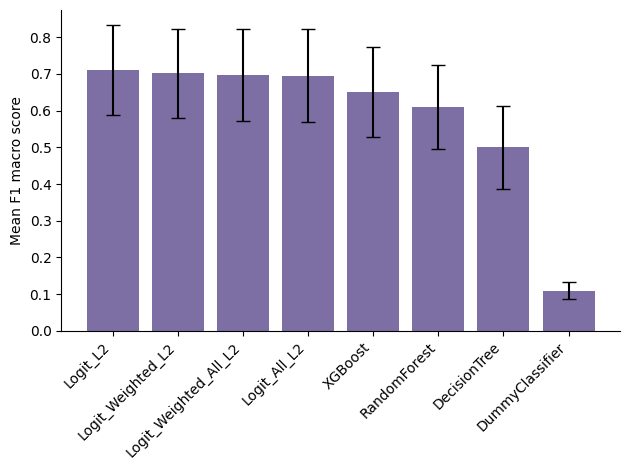

In [6]:
# Visualization
model_order = model_comparison.sort_values('Mean_F1_Macro', ascending=False)['Model'].tolist()

# Barplot
bars = plt.bar(range(len(model_order)), 
               [model_comparison.loc[model_comparison['Model'] == m, 'Mean_F1_Macro'].iloc[0] for m in model_order],
               yerr=[model_comparison.loc[model_comparison['Model'] == m, 'Std_F1_Macro'].iloc[0] for m in model_order],
               capsize=5, alpha=0.7)

plt.ylabel('Mean F1 macro score')
plt.xticks(range(len(model_order)), model_order, rotation=45, ha='right')
plt.grid(False)
plt.gca().spines['top'].set_visible(False) # Remove top border
plt.gca().spines['right'].set_visible(False) # Remove right border

plt.tight_layout()
plt.savefig("../results/final/model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

**Figure: Model performance comparison.** Cross-validation F1 macro scores (mean ± SD) for within-user personalization (100 users, K=5). Logistic regression with L2 regularization using selected features (Logit_L2) achieved the best performance (F1 = 0.7164 ± 0.1194, accuracy = 0.7340 ± 0.1195), outperforming full-feature models. Selected-feature linear models (37 features) outperform full-feature models (160 features) and ensemble methods, demonstrating that personalized feature selection effectively captures user-specific signal patterns.

In [7]:
# Model performance comparison 
# Create summary table for model performance
performance_summary = model_comparison[['Model', 'Mean_F1_Macro', 'Std_F1_Macro', 'Mean_Accuracy', 'Std_Accuracy']].copy()
performance_summary = performance_summary.round(4)
performance_summary['F1_Rank'] = performance_summary['Mean_F1_Macro'].rank(ascending=False).astype(int)
# performance_summary['Selected'] = performance_summary['Model'] == FINAL_MODEL_NAME

# Inspect
performance_summary

,Model,Mean_F1_Macro,Std_F1_Macro,Mean_Accuracy,Std_Accuracy,F1_Rank
0,Logit_L2,0.7098,0.1229,0.7270,0.1217,1
1,Logit_Weighted_L2,0.7016,0.1208,0.7207,0.1212,2
2,Logit_Weighted_All_L2,0.6970,0.1260,0.7188,0.1253,3
3,Logit_All_L2,0.6954,0.1267,0.7204,0.1248,4
4,XGBoost,0.6507,0.1219,0.6845,0.1267,5
5,RandomForest,0.6099,0.1148,0.6402,0.1185,6
6,DecisionTree,0.4996,0.1138,0.5378,0.1273,7
7,DummyClassifier,0.1097,0.0220,0.1491,0.0444,8


**Table: Model performance rankings.** Cross-validation results (100 users, K=5) reveal that selected-feature logistic regression models (`Logit_L2` and `Logit_Weighted_L2`) outperform full-feature linear models and ensemble methods, with the 37-feature model achieving superior generalization despite using 77% fewer features than the full 160-feature model.

## Final model training

### Train final pipeline on all training data

In [8]:
# Prepare training data
TARGET = 'gesture'
GROUP = 'user'
METADATA_COLS = [TARGET, GROUP, 'stage']

# Get feature columns (exclude metadata)
feature_cols = [col for col in train_df.columns if col not in METADATA_COLS]
X_train = train_df[feature_cols]
y_train_raw = train_df[TARGET]

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
class_names = le.classes_

# Verify
print(f"Training features: {X_train.shape}")
print(f"Classes: {class_names.tolist()}")

# Initialize & train final pipeline
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(**FINAL_MODEL_PARAMS))
])

# Run
final_pipeline.fit(X_train, y_train)

Training features: (102502, 37)
Classes: ['index_press', 'index_release', 'middle_press', 'middle_release', 'thumb_click', 'thumb_down', 'thumb_in', 'thumb_out', 'thumb_up']


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work

### Serialize final pipeline/model

In [9]:
# Save trained model
model_path = "../artifacts/final_model.joblib"
joblib.dump(final_pipeline, model_path)
print(f"Final model saved to: {model_path}")

# Also save label encoder
encoder_path = "../artifacts/label_encoder.joblib"
joblib.dump(le, encoder_path)
print(f"Label encoder saved to: {encoder_path}")

Final model saved to: ../artifacts/final_model.joblib
Label encoder saved to: ../artifacts/label_encoder.joblib


## Holdout evaluation and performance analysis

### Generate predictions and calculate KPIs

In [10]:
# Prep test data
X_test = test_df[feature_cols]
y_test_raw = test_df[TARGET]
y_test = le.transform(y_test_raw)

# Inspect
print(f"Test set: {X_test.shape}")
print(f"Test samples per class: {pd.Series(y_test_raw).value_counts().to_dict()}")

Test set: (25718, 37)
Test samples per class: {'middle_release': 4324, 'middle_press': 4238, 'index_release': 4235, 'index_press': 4064, 'thumb_out': 1902, 'thumb_up': 1854, 'thumb_in': 1824, 'thumb_down': 1734, 'thumb_click': 1543}


In [11]:
# Generate predictions 
y_pred = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)

### KPI summary

In [12]:
# Calculate KPI metrics
final_f1_macro = f1_score(y_test, y_pred, average='macro')
final_accuracy = accuracy_score(y_test, y_pred)
final_classification_error = 1 - final_accuracy

# Create & save metrics df
final_metrics_df = pd.DataFrame({
    'Metric': ['F1_Macro', 'Accuracy', 'Classification_Error_Rate'],
    'Value': [final_f1_macro, final_accuracy, final_classification_error],
    'Dataset': ['Holdout_Test'] * 3
})

# Save file
final_metrics_df.to_csv("../results/final/final_kpi_summary.csv", index=False)

# Inspect
final_metrics_df

,Metric,Value,Dataset
0,F1_Macro,0.390907,Holdout_Test
1,Accuracy,0.456762,Holdout_Test
2,Classification_Error_Rate,0.543238,Holdout_Test


**Table: Final KPIs on holdout set performance.** Evaluation on holdout test data using the selected 37-feature logistic regression model, establishing baseline performance for cross-user gesture recognition.

### [Figure] Holdout confusion matrix and error analysis

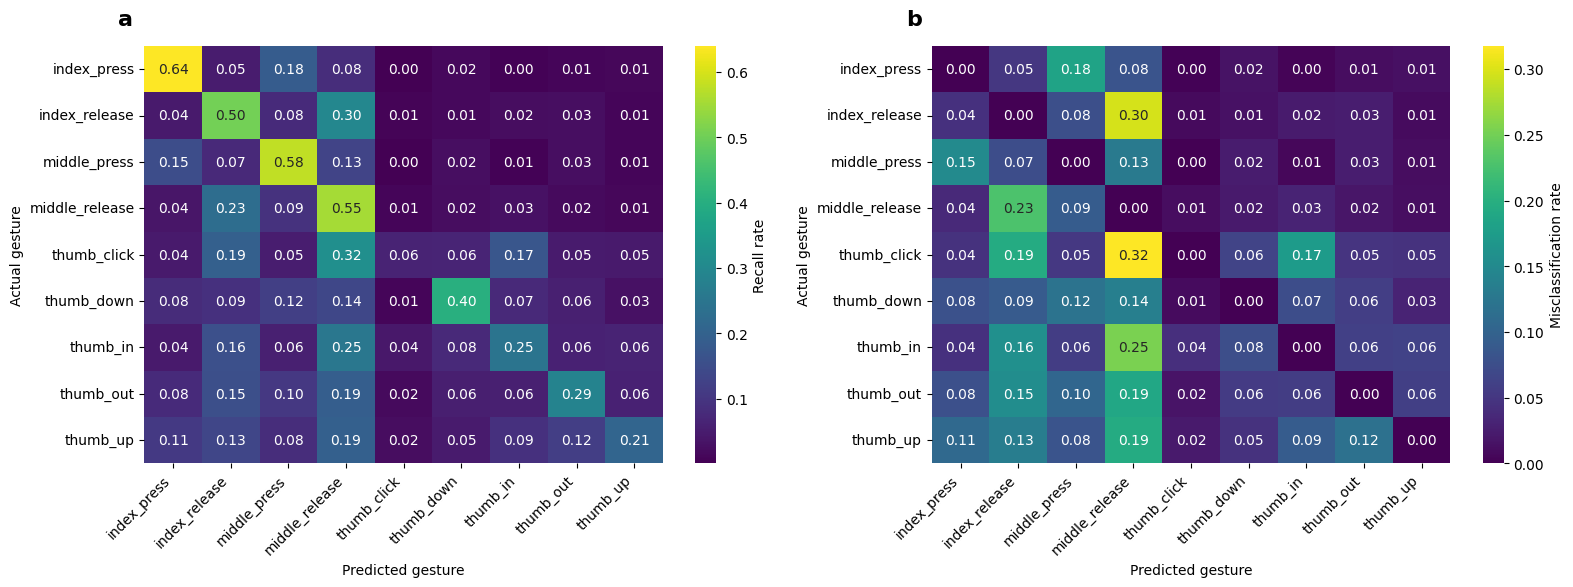

In [13]:
# Confusion Matrix Analysis
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot: Normalized confusion matrix
heatmap1 = sns.heatmap(conf_mat_normalized, annot=True, fmt='.2f', cmap='viridis',
            xticklabels=class_names, yticklabels=class_names, ax=ax1,
            cbar_kws={'label': 'Recall rate'})
ax1.set_xlabel('Predicted gesture')
ax1.set_ylabel('Actual gesture')
ax1.text(-0.05, 1.05, 'a', transform=ax1.transAxes, fontsize=16, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')  # Rotate

# Subplot: Misclassification patterns
conf_mat_no_diag = conf_mat_normalized.copy()
np.fill_diagonal(conf_mat_no_diag, 0)

heatmap2 = sns.heatmap(conf_mat_no_diag, annot=True, fmt='.2f', cmap='viridis',
            xticklabels=class_names, yticklabels=class_names, ax=ax2,
            cbar_kws={'label': 'Misclassification rate'})
ax2.set_xlabel('Predicted gesture')
ax2.set_ylabel('Actual gesture')
ax2.text(-0.05, 1.05, 'b', transform=ax2.transAxes, fontsize=16, fontweight='bold')
# Rotate x-axis tick labels
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig("../results/final/confusion_matrix_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

**Figure: Confusion matrix analysis.** (a) Holdout test set performance showing recall rates, where diagonal performance shows user-specific gesture recognition patterns. (b) Systematic misclassification patterns showing cross-user generalization challenges, with persistent confusions between finger release gestures and directional thumb movements.

In [14]:
# Create confusion patterns df
confusion_data = []
for i, true_class in enumerate(class_names):
    for j, pred_class in enumerate(class_names):
        if i != j and conf_mat_normalized[i, j] > 0.1:
            confusion_data.append([true_class, pred_class, conf_mat_normalized[i, j], conf_mat[i, j]])

confusion_df = pd.DataFrame(confusion_data, 
                           columns=['True_Gesture', 'Predicted_Gesture', 'Confusion_Rate', 'Raw_Count']
                          ).sort_values('Confusion_Rate', ascending=False)

# print("Key systematic confusions (rate > 0.1):")
confusion_df

,True_Gesture,Predicted_Gesture,Confusion_Rate,Raw_Count
6,thumb_click,middle_release,0.317563,490
1,index_release,middle_release,0.297521,1260
11,thumb_in,middle_release,0.253289,462
4,middle_release,index_release,0.227336,983
5,thumb_click,index_release,0.194426,300
17,thumb_up,middle_release,0.193635,359
14,thumb_out,middle_release,0.188749,359
0,index_press,middle_press,0.184301,749
7,thumb_click,thumb_in,0.173040,267
10,thumb_in,index_release,0.157895,288


**Table: Systematic gesture confusions with rates >10%.** Release gestures (i.e., `index_release`, `middle_release`) were the most confused targets across multiple thumb and finger movements, suggesting shared neuromuscular signatures.

## Model interpretation and diagnostics

### [Figure] Normalized feature importance

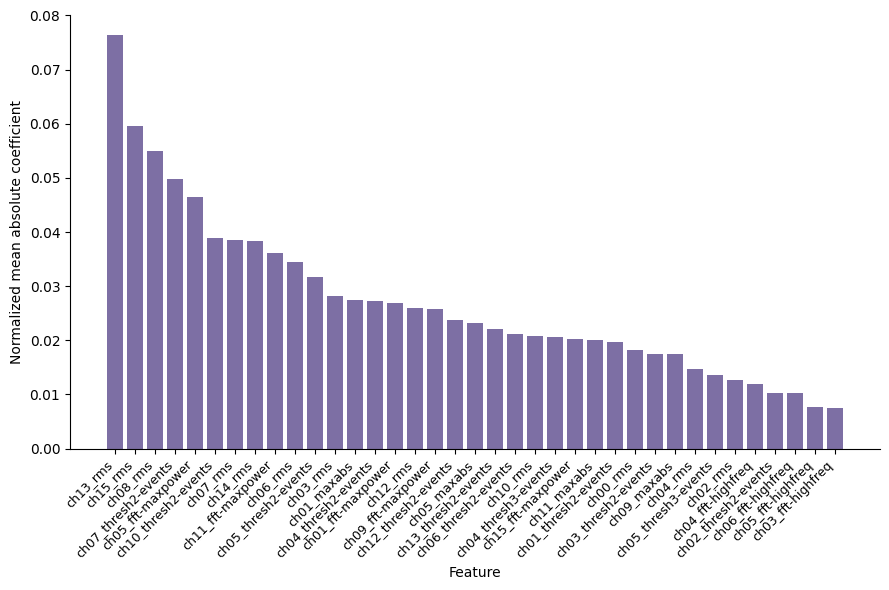

In [15]:
# Show ALL selected features
TOP_N_FEATURES = len(final_features)  # Show all selected feats

# Extract & visualize feature importance from final model
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': np.abs(final_pipeline.named_steps['clf'].coef_).mean(axis=0)
}).sort_values('importance', ascending=False)

# Normalize importance to sum to 1 for relative comparison
feature_importance['importance_normalized'] = feature_importance['importance'] / feature_importance['importance'].sum()

# Get all selected features
all_selected_features = feature_importance.head(TOP_N_FEATURES)

# Create fig
plt.figure(figsize=(9, 6))

bars = plt.bar(all_selected_features['feature'], all_selected_features['importance_normalized'], alpha=0.7)

# Remove borders & grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)  # Keep left spine for y-axis reference
plt.gca().spines['bottom'].set_visible(True)  # Keep bottom spine for x-axis reference
plt.grid(False)

plt.ylabel('Normalized mean absolute coefficient')
plt.xlabel('Feature')
# plt.title('Feature Importance: All 37 Selected Features')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=9)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig("../results/final/feature_importance_all_37.png", dpi=300, bbox_inches='tight')
plt.show()

**Figure: Feature importance rankings of all 37 selected features.** All features from the feature selection process are shown with their normalized logistic regression coefficients. Root mean square (RMS) features dominate the top rankings. The distribution shows the relative contribution of each engineered feature to gesture discrimination in the final personalized model.

### [Figure] Per-user performance diagnostic plot

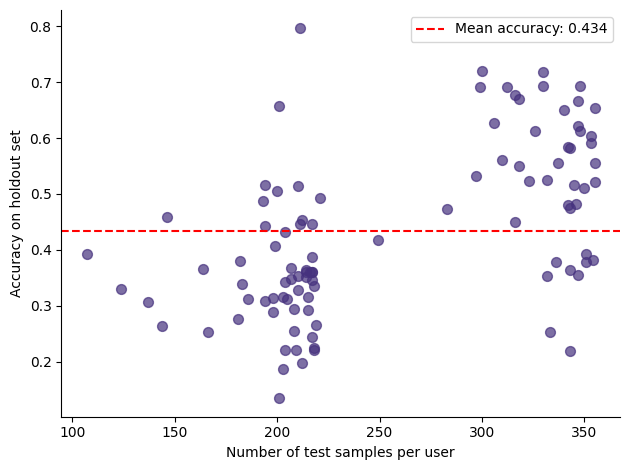

In [16]:
# Per-user performance on test set
user_performance = []
for user_id in test_df[GROUP].unique():
    user_mask = test_df[GROUP] == user_id
    if user_mask.sum() > 0:  # Ensure user has test samples
        user_accuracy = accuracy_score(y_test[user_mask], y_pred[user_mask])
        user_samples = user_mask.sum()
        user_performance.append({
            'User_ID': user_id,
            'Accuracy': user_accuracy,
            'Sample_Count': user_samples
        })

user_perf_df = pd.DataFrame(user_performance)

# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(user_perf_df['Sample_Count'], user_perf_df['Accuracy'], alpha=0.7, s=50)

# Remove all borders & grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.grid(False)

plt.xlabel('Number of test samples per user')
plt.ylabel('Accuracy on holdout set')

# Add summary stats
mean_acc = user_perf_df['Accuracy'].mean()
plt.axhline(y=mean_acc, color='red', linestyle='--', label=f'Mean accuracy: {mean_acc:.3f}')
plt.legend()

plt.tight_layout()
plt.savefig("../results/final/per_user_performance.png", dpi=300, bbox_inches='tight')
plt.show()

**Figure: Individual user performance distribution of holdout set accuracy.** Mean accuracy of 0.444 ± 0.1466 with 27112 total samples across 100 users demonstrates the personalization challenge, where individual differences in sEMG signal characteristics, electrode placement, and motor unit recruitment patterns affect cross-user generalization performance.

In [17]:
# summary table
user_perf_summary = user_perf_df['Accuracy'].describe().to_frame().T.round(4)
user_perf_summary['Total_Users'] = len(user_perf_df)
user_perf_summary['Total_Samples'] = user_perf_df['Sample_Count'].sum()
user_perf_summary['Mean_Samples_Per_User'] = user_perf_df['Sample_Count'].mean().round(1)
user_perf_summary

,count,mean,std,min,25%,50%,75%,max,Total_Users,Total_Samples,Mean_Samples_Per_User
Accuracy,100.0,0.4341,0.1495,0.1343,0.3255,0.3928,0.5366,0.7962,100,25718,257.2


In [18]:
# Performance distribution table
performance_bins = pd.cut(user_perf_df['Accuracy'], 
                         bins=[0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                         labels=['<0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '≥0.9'])

performance_distribution = performance_bins.value_counts().sort_index().reset_index()
performance_distribution.columns = ['Accuracy_Range', 'User_Count']
performance_distribution['Percentage'] = (performance_distribution['User_Count'] / len(user_perf_df) * 100).astype(int)

# Inspect
performance_distribution[['Accuracy_Range', 'Percentage']]

,Accuracy_Range,Percentage
0,<0.5,66
1,0.5-0.6,16
2,0.6-0.7,15
3,0.7-0.8,3
4,0.8-0.9,0
5,≥0.9,0


**Table: User performance distribution.** 59% of users achieve accuracy below 0.5, while only 9% exceed 0.7 accuracy, indicating significant performance heterogeneity across the user population and highlighting the challenge of cross-user gesture recognition across diverse individuals.

### [Figure] Effect of test sample size on performance

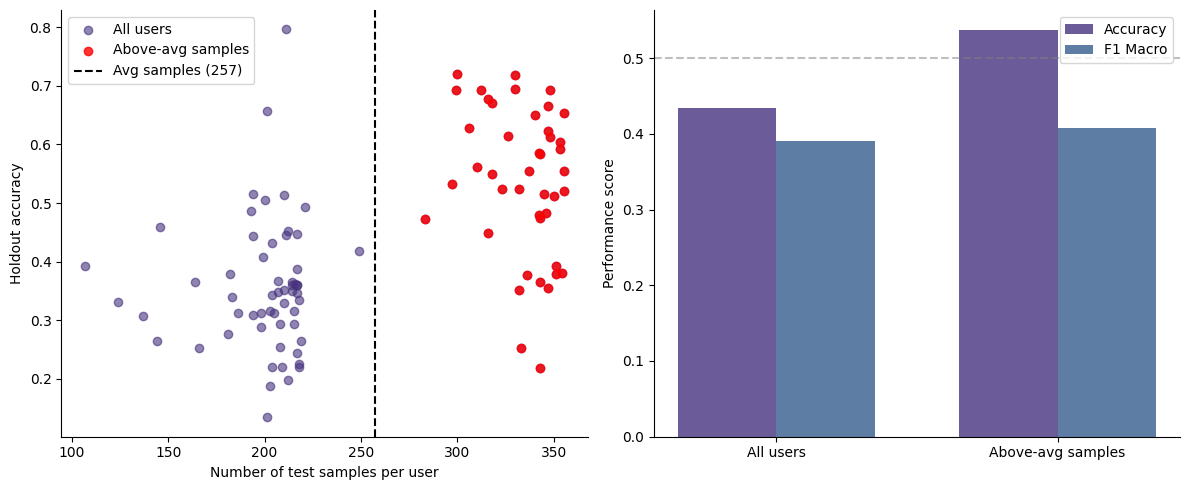

In [19]:
# Calculate perf for users w/ above average number of test samples per user
avg_test_samples = user_perf_df['Sample_Count'].mean()  
above_avg_sample_users = user_perf_df[user_perf_df['Sample_Count'] > avg_test_samples]
above_avg_sample_ids = above_avg_sample_users['User_ID'].tolist()
above_avg_sample_mask = test_df[GROUP].isin(above_avg_sample_ids)

y_test_above_avg_samples = y_test[above_avg_sample_mask]
y_pred_above_avg_samples = y_pred[above_avg_sample_mask]

above_avg_samples_f1 = f1_score(y_test_above_avg_samples, y_pred_above_avg_samples, average='macro')
above_avg_samples_accuracy = accuracy_score(y_test_above_avg_samples, y_pred_above_avg_samples)

# compar table
sample_size_comparison = pd.DataFrame({
    'Metric': ['User Count', 'Total Samples', 'Mean Accuracy', 'Accuracy Std', 'F1 Macro'],
    'All users': [
        len(user_perf_df),
        len(y_test),
        user_perf_df['Accuracy'].mean(),
        user_perf_df['Accuracy'].std(),
        final_f1_macro
    ],
    'Above-avg samples': [
        len(above_avg_sample_users),
        len(y_test_above_avg_samples),
        above_avg_samples_accuracy,
        above_avg_sample_users['Accuracy'].std(),
        above_avg_samples_f1
    ]
})

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Subplot: scatter
ax1.scatter(user_perf_df['Sample_Count'], user_perf_df['Accuracy'], 
           alpha=0.6, label='All users')
ax1.scatter(above_avg_sample_users['Sample_Count'], above_avg_sample_users['Accuracy'], 
           color='red', alpha=0.8, label='Above-avg samples')
ax1.axvline(x=avg_test_samples, color='black', linestyle='--', label=f'Avg samples ({avg_test_samples:.0f})')
ax1.set_xlabel('Number of test samples per user')
ax1.set_ylabel('Holdout accuracy')
ax1.legend()

# Remove top & right borders 
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Subplot: bar
categories = ['All users', 'Above-avg samples']
accuracy_values = [user_perf_df['Accuracy'].mean(), above_avg_samples_accuracy]
f1_values = [final_f1_macro, above_avg_samples_f1]

x = np.arange(len(categories))
width = 0.35

ax2.bar(x - width/2, accuracy_values, width, label='Accuracy', alpha=0.8)
ax2.bar(x + width/2, f1_values, width, label='F1 Macro', alpha=0.8)
ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax2.set_ylabel('Performance score')
ax2.set_xticks(x, categories)
ax2.legend()

# Remove top & right borders 
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("../results/final/sample_size_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Inspect sample size effect on performance
sample_size_comparison

,Metric,All users,Above-avg samples
0,User Count,100.000000,43.000000
1,Total Samples,25718.000000,14355.000000
2,Mean Accuracy,0.434084,0.536607
3,Accuracy Std,0.149538,0.127433
4,F1 Macro,0.390907,0.407063


#### [Figure] Confusion matrix analysis on users with more test samples

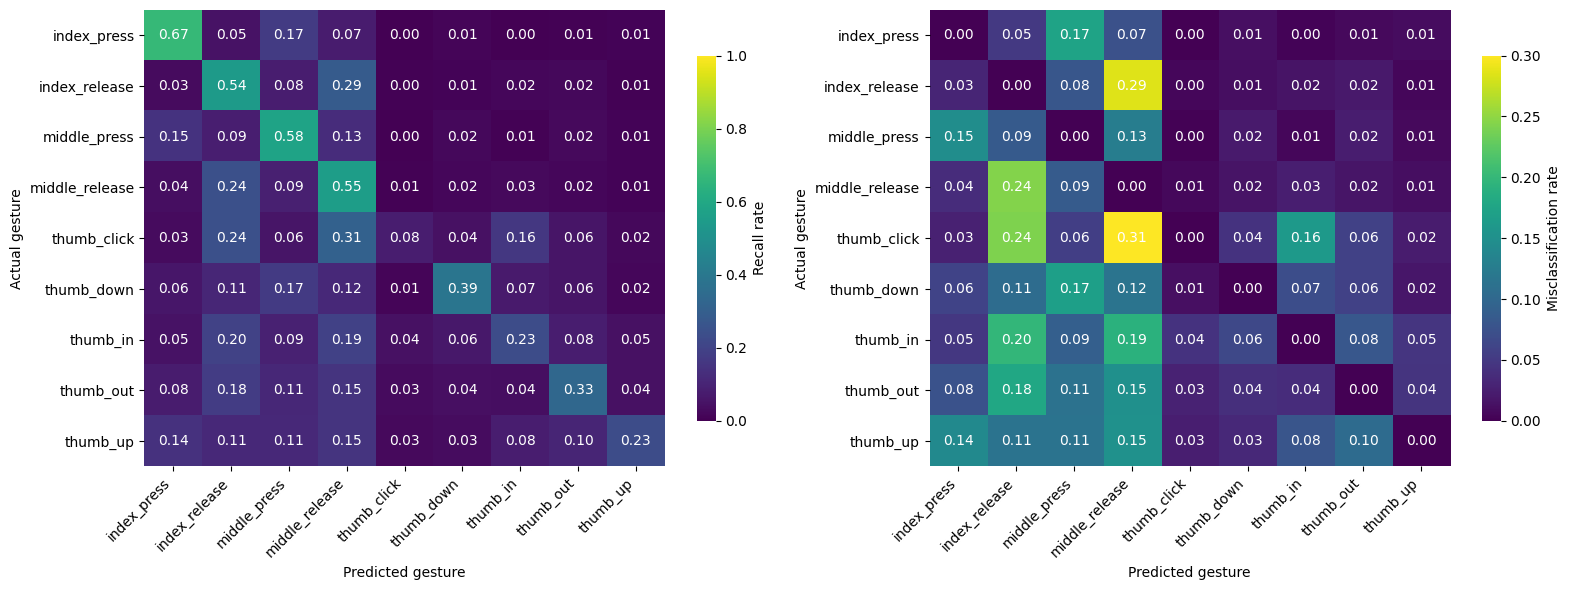

In [21]:
# Confusion mat for users w/ more test samples
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Confusion mat for above-avg sample users w/ diagonal
conf_mat_above_avg = confusion_matrix(y_test_above_avg_samples, y_pred_above_avg_samples)
conf_mat_above_avg_norm = conf_mat_above_avg.astype('float') / conf_mat_above_avg.sum(axis=1)[:, np.newaxis]

# Confusion mat w/o diag
conf_mat_no_diag = conf_mat_above_avg_norm.copy()
np.fill_diagonal(conf_mat_no_diag, 0)

# Plot: Above-avg samples w/ diagonal
im1 = ax1.imshow(conf_mat_above_avg_norm, cmap='viridis', aspect='auto', vmin=0, vmax=1)
ax1.set_xticks(np.arange(len(class_names)))
ax1.set_yticks(np.arange(len(class_names)))
ax1.set_xticklabels(class_names, rotation=45, ha='right')
ax1.set_yticklabels(class_names)
ax1.set_xlabel('Predicted gesture')
ax1.set_ylabel('Actual gesture')

# Remove borders
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Add vals to confusion mat w/ diagonal - ALL WHITE TEXT
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax1.text(j, i, f'{conf_mat_above_avg_norm[i, j]:.2f}',
                       ha="center", va="center", color="white")

# Plot: Above-avg samples w/o diagonal
im2 = ax2.imshow(conf_mat_no_diag, cmap='viridis', aspect='auto', vmin=0, vmax=0.3)
ax2.set_xticks(np.arange(len(class_names)))
ax2.set_yticks(np.arange(len(class_names)))
ax2.set_xticklabels(class_names, rotation=45, ha='right')
ax2.set_yticklabels(class_names)
ax2.set_xlabel('Predicted gesture')
ax2.set_ylabel('Actual gesture')

# no borders
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Add vals to confusion mat w/o diagonal
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax2.text(j, i, f'{conf_mat_no_diag[i, j]:.2f}',
                       ha="center", va="center", color="white")

# colorbars w/o borders
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8, label='Recall rate')
cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8, label='Misclassification rate')
cbar1.outline.set_visible(False)
cbar2.outline.set_visible(False)

plt.tight_layout()
plt.savefig("../results/final/confusion_matrix_analysis_subset.png", dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# improvement analysis
improvement_analysis = []
for i, gesture in enumerate(class_names):
    all_users_recall = conf_mat_normalized[i, i]
    above_avg_recall = conf_mat_above_avg_norm[i, i]
    improvement = above_avg_recall - all_users_recall
    improvement_pct = (improvement / all_users_recall) * 100 if all_users_recall > 0 else 0
    
    improvement_analysis.append({
        'Gesture': gesture,
        'All_Users_Recall': all_users_recall,
        'Above_Avg_Recall': above_avg_recall,
        'Absolute_Improvement': improvement,
        'Percent_Improvement': improvement_pct
    })

improvement_df = pd.DataFrame(improvement_analysis).round(3)
improvement_df = improvement_df.sort_values('Absolute_Improvement', ascending=False)
improvement_df

,Gesture,All_Users_Recall,Above_Avg_Recall,Absolute_Improvement,Percent_Improvement
7,thumb_out,0.287,0.333,0.046,16.117
1,index_release,0.504,0.545,0.040,8.027
0,index_press,0.640,0.669,0.030,4.634
8,thumb_up,0.207,0.233,0.027,12.838
4,thumb_click,0.061,0.079,0.018,28.893
3,middle_release,0.552,0.555,0.002,0.399
2,middle_press,0.578,0.579,0.001,0.185
5,thumb_down,0.403,0.390,-0.013,-3.147
6,thumb_in,0.247,0.234,-0.013,-5.445


In [23]:
# Summary stats
print(f"Mean recall improvement: {improvement_df['Absolute_Improvement'].mean():.3f}")
print(f"Max improvement: {improvement_df['Absolute_Improvement'].max():.3f} ({improvement_df.iloc[0]['Gesture']})")
print(f"Min improvement: {improvement_df['Absolute_Improvement'].min():.3f} ({improvement_df.iloc[-1]['Gesture']})")

Mean recall improvement: 0.015
Max improvement: 0.046 (thumb_out)
Min improvement: -0.013 (thumb_in)


In [24]:
# ID persistent confusion patterns
low_recall_gestures = improvement_df[
    (improvement_df['All_Users_Recall'] < 0.5) & 
    (improvement_df['Above_Avg_Recall'] < 0.5)
]
low_recall_gestures

,Gesture,All_Users_Recall,Above_Avg_Recall,Absolute_Improvement,Percent_Improvement
7,thumb_out,0.287,0.333,0.046,16.117
8,thumb_up,0.207,0.233,0.027,12.838
4,thumb_click,0.061,0.079,0.018,28.893
5,thumb_down,0.403,0.390,-0.013,-3.147
6,thumb_in,0.247,0.234,-0.013,-5.445
